In [31]:
from tenLoader import TenVideoDataset, normalize, TenVideoTest, TenVideoInfer
from model import BaseFeatup
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random
import time
import re

In [26]:
model_name = "featup_10"
loss_log_path = f"./log/{model_name}_loss.json"
iou_log_path = f"./log/{model_name}_iou.json"
model_path = f"./model/{model_name}.pth"
log_path = f"./log/{model_name}.log"

In [64]:
dict_loss = {}
dict_iou = {}
with open(loss_log_path, "r") as f:
    dict_loss = json.load(f)
with open(iou_log_path, "r") as f:
    dict_iou = json.load(f)

In [27]:
# log_record = ""
# with open(log_path, "r") as f:
#     log_record = f.read()

In [29]:
# log_records = log_record.split("\n")
# log_records.__len__()

1052

In [65]:
# for record in log_records:
#     epoch_num = re.findall(r"Epoch (\d+)", record)
#     if len(epoch_num) == 0:
#         continue
#     epoch_num = int(epoch_num[0])
#     loss = re.findall(r"Loss (\d+\.\d+)", record)
#     if len(loss) != 0:
#         dict_loss[epoch_num] = float(loss[0])
#         continue
#     iou = re.findall(r"IOU (\d+\.\d+)", record)
#     if len(iou) != 0:
#         dict_iou[epoch_num] = float(iou[0])
        

In [68]:
print(dict_iou)

{50: 0.3454, 90: 0.4765, 120: 0.4464, 140: 0.46, 160: 0.4723, 180: 0.4298, 200: 0.4538, 220: 0.5137, 240: 0.5298, 260: 0.5393, 280: 0.4889, 300: 0.5234, 320: 0.5409, 340: 0.557, 360: 0.5391, 380: 0.5408, 400: 0.5838, 420: 0.5947, 440: 0.5693, 460: 0.573, 480: 0.5918, 500: 0.5959, 520: 0.6364, 540: 0.6143, 560: 0.6259, 580: 0.6497, 600: 0.6662, 620: 0.6672, 640: 0.65, 660: 0.6359, 680: 0.6541, 700: 0.6812, 720: 0.6766, 740: 0.638, 760: 0.6537, 780: 0.6568, 800: 0.6784, 820: 0.645, 840: 0.6682, 860: 0.6694, 880: 0.6698, 900: 0.6575, 920: 0.6591, 940: 0.6561, 960: 0.6778, 980: 0.6916, 1000: 0.6797}


In [69]:
dict_iou[1000]

0.6797

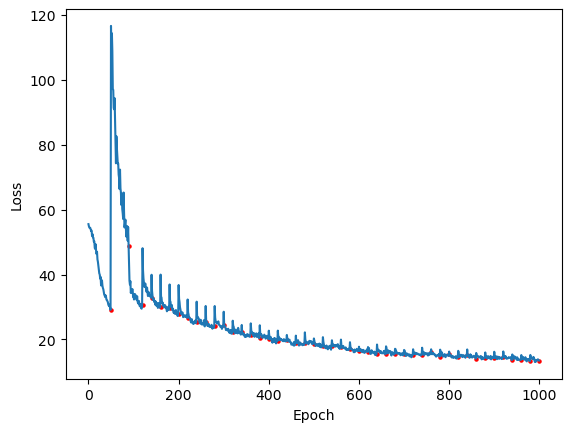

In [71]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plot the update points
plt.scatter(list(dict_iou.keys()), [dict_loss[i-1] for i in list(dict_iou.keys())], c="r", s=5)
plt.show()

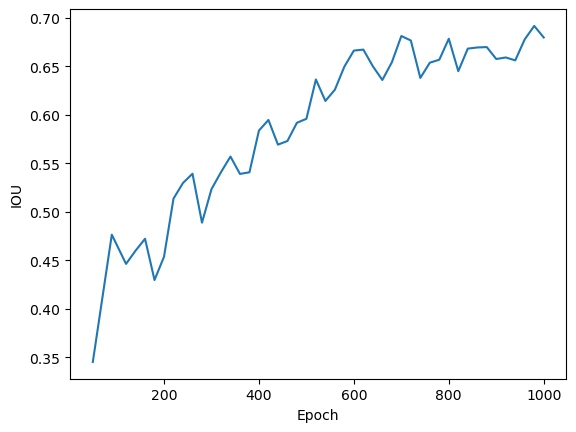

In [72]:
# plot the iou
plt.plot(list(dict_iou.keys()), list(dict_iou.values()))
plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.show()

In [5]:
# load model
model = BaseFeatup()
model.load_state_dict(torch.load('./model/featup_10.pth'))

<All keys matched successfully>

In [7]:
testset = TenVideoTest()

model_infer = TenVideoInfer(testset)


In [8]:
model_infer.infer_model(model)

In [9]:
model_infer.get_total_iou()

0.6797131941903819

IoU 0.5161437237236317


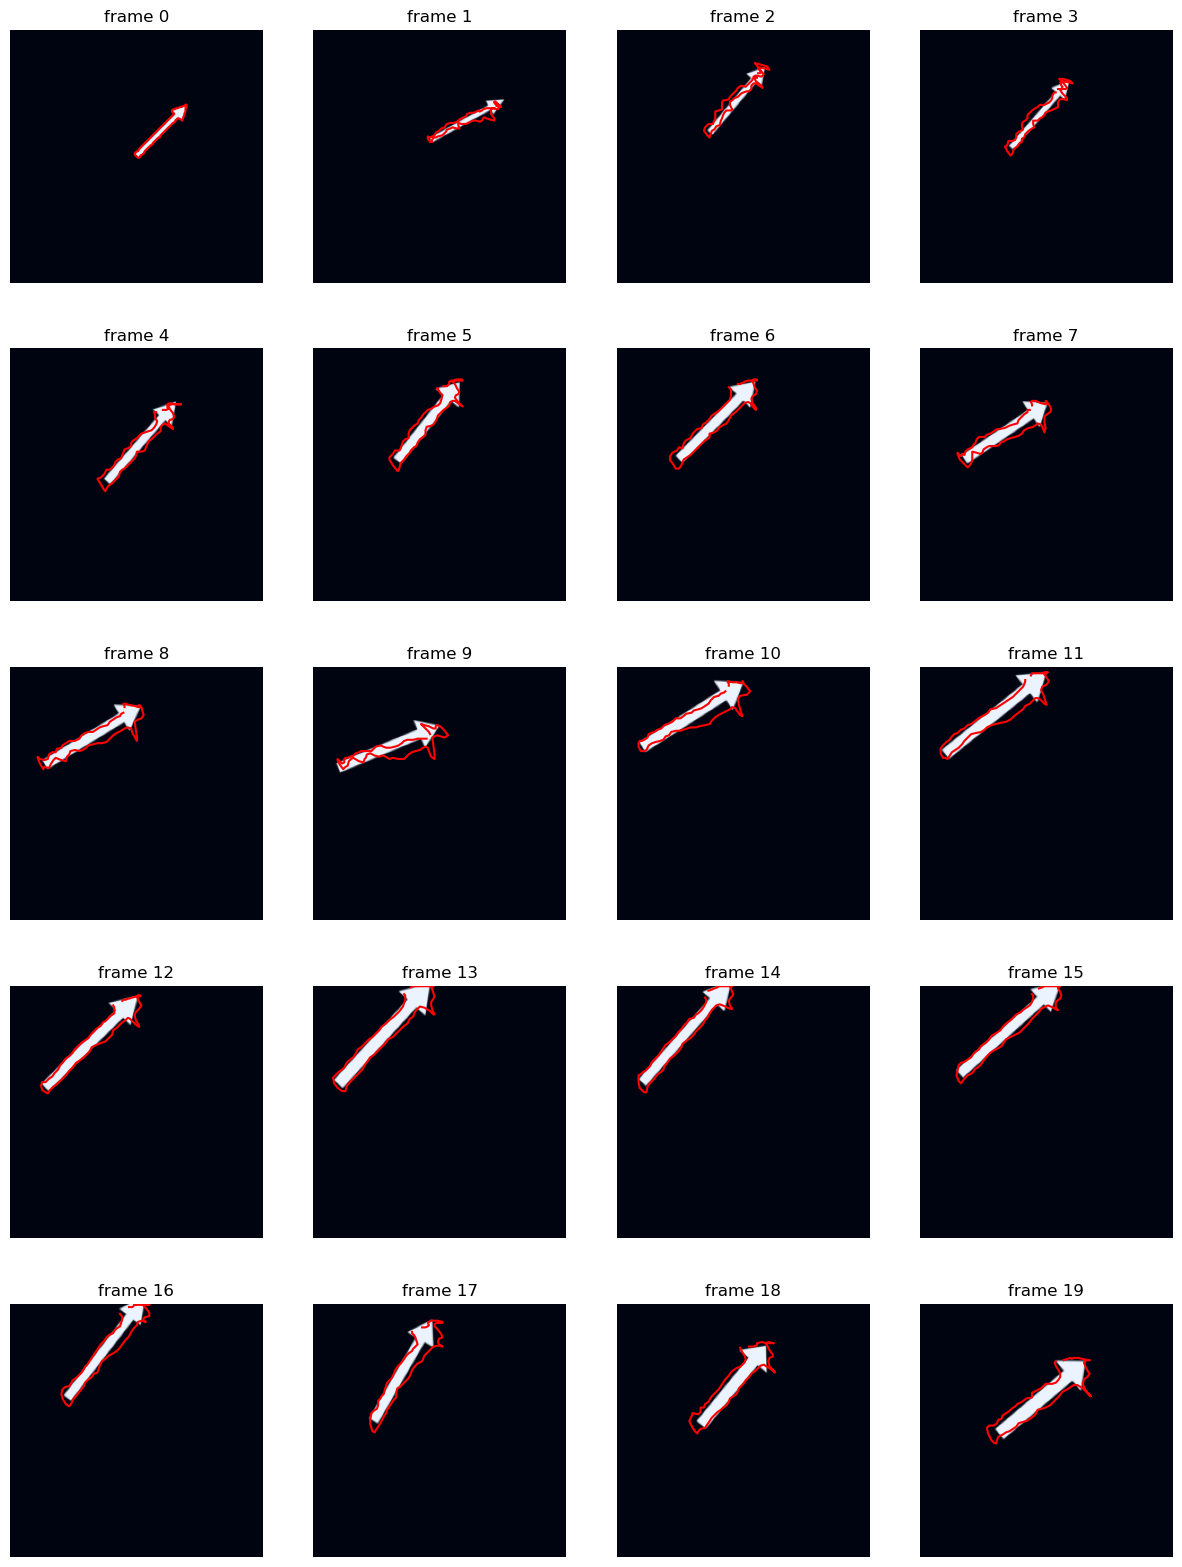

In [86]:
video_idx = 0
frame_idx = 0
print("IoU", model_infer.get_video_iou(video_idx))
model_infer.show_infer_result(video_idx, 0)

In [14]:
test_testset = TenVideoTest("./10video/test/total_data.json")
test_model_infer = TenVideoInfer(test_testset)

In [78]:
test_model_infer.infer_model(model)

In [79]:
test_model_infer.get_total_iou()

0.44574414004406276

IoU 0.16967171246526142


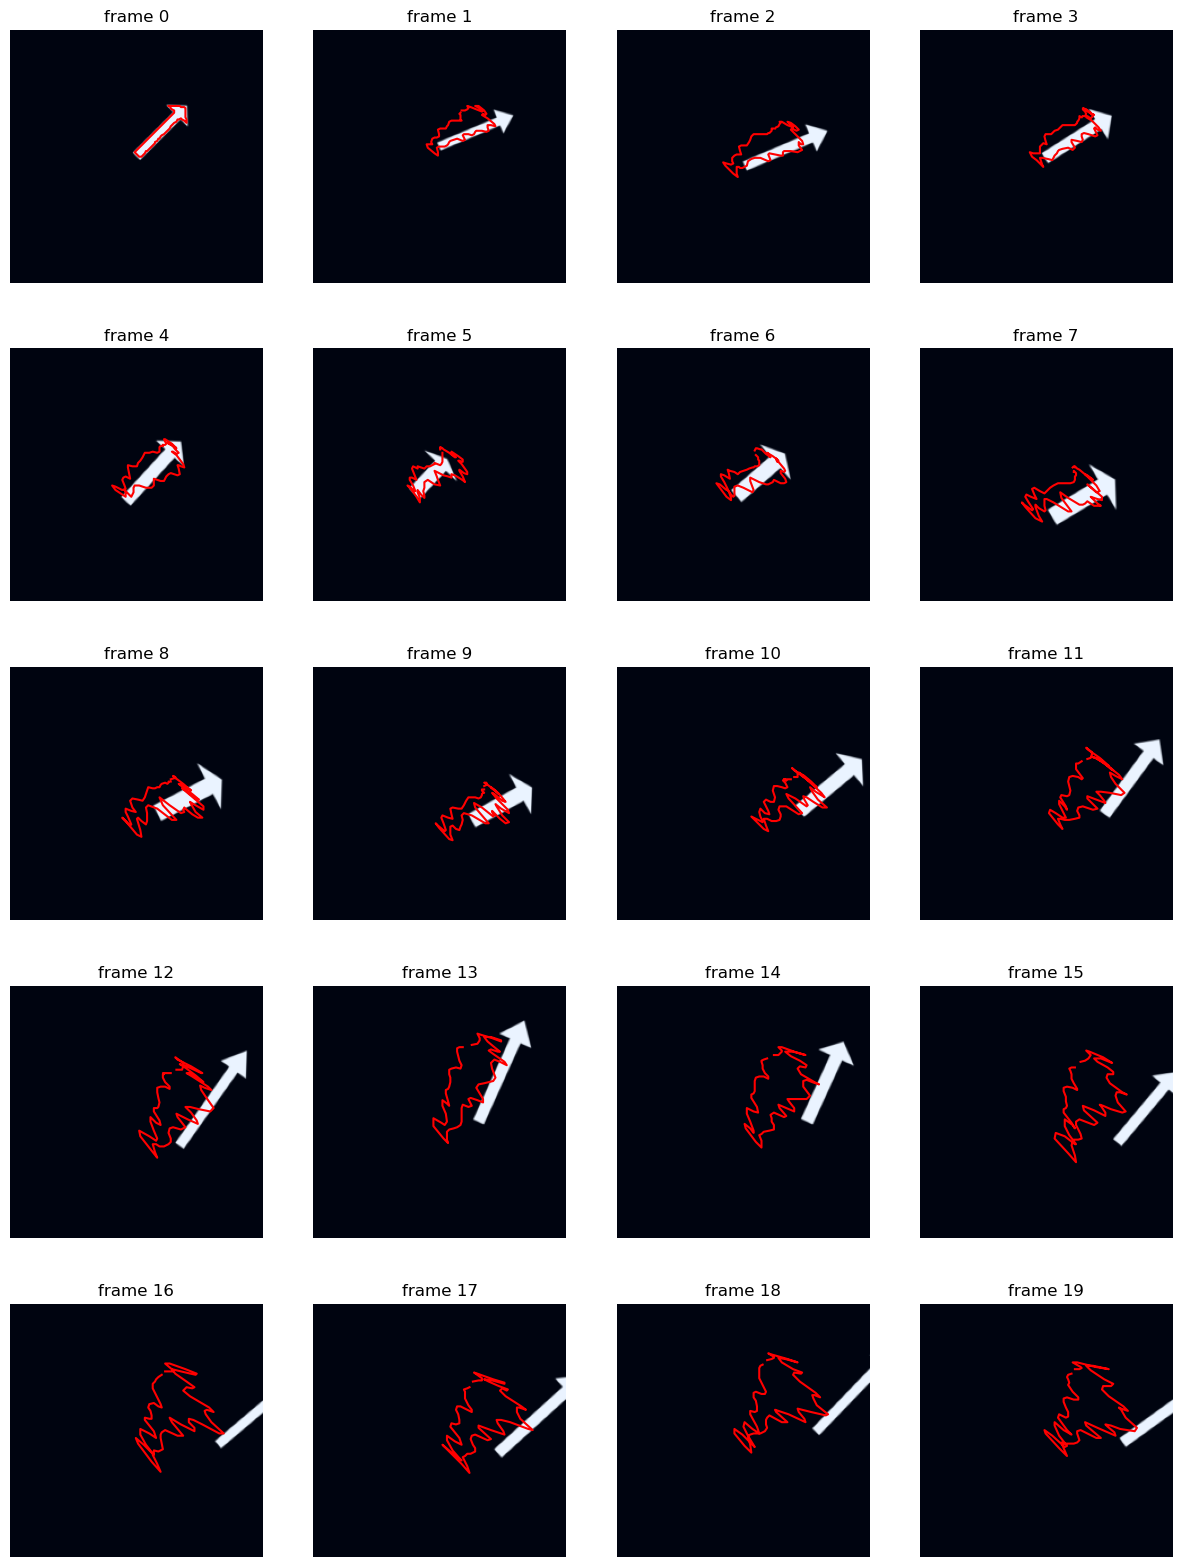

In [85]:
video_idx = 0
frame_idx = 0
print("IoU", test_model_infer.get_video_iou(video_idx))
test_model_infer.show_infer_result(video_idx, 0)